# E-commerce Customer Analytics

This notebook demonstrates a complete pipeline—from raw data cleaning to RFM segmentation and key visualizations—using the UCI Online Retail dataset.  
**Goals:**
1. Clean and preprocess raw transactions  
2. Compute RFM (Recency, Frequency, Monetary) metrics and quintile scores  
3. Generate actionable static visualizations  
4. Export results for downstream dashboards and reporting  


### Import Libraries and Load Dataset


## Table of Contents

1. [Setup & Imports](#setup)  
2. [Data Loading & Cleaning](#cleaning)  
3. [RFM Metric Calculation](#rfm-metrics)  
4. [RFM Scoring & Segmentation](#rfm-scoring)  
5. [Key Visualizations](#visualizations)  
6. [Export Results](#export)  
7. [Next Steps](#next-steps)  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Global styles
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 4)


## 1. Data Loading & Cleaning

Load the raw Excel file and perform basic cleaning:
- Drop duplicates  
- Remove cancelled orders (`InvoiceNo` starts with "C")  
- Remove transactions with missing `CustomerID`  


In [2]:
# Load raw data
df = pd.read_excel("data/Online Retail.xlsx")

# Initial glimpse
df.head(), df.info()

# Clean data
df_clean = (
    df
    .drop_duplicates()
    .loc[~df['InvoiceNo'].astype(str).str.startswith('C')]
    .dropna(subset=['CustomerID'])
)

# Save cleaned raw (optional)
df_clean.to_csv("data/cleaned_retail.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 2. RFM Metric Calculation

For each customer:
- **Recency** = days since last purchase (using snapshot_date)  
- **Frequency** = number of unique invoices  
- **MonetaryValue** = total spend (UnitPrice × Quantity)  


In [3]:
# Reference date = one day after last InvoiceDate
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics
rfm = (
    df_clean
    .groupby('CustomerID')
    .agg(
        Recency      = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
        Frequency    = ('InvoiceNo', 'nunique'),
        MonetaryValue= ('UnitPrice', lambda x: (x * df_clean.loc[x.index, 'Quantity']).sum())
    )
)

rfm.head()


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## 3. RFM Scoring & Segmentation

1. Compute percent-rank for each metric (0–1).  
2. Map percent-rank to quintile scores 1–5.  
3. Invert Recency score so that more recent = higher score.  
4. Concatenate into a 3-digit `RFM_Segment` and sum into `RFM_Score` (3–15).


In [4]:
def to_quintile_score(series, invert=False):
    pct   = series.rank(method='min', pct=True)
    score = (pct * 5).astype(int) + 1
    score = score.clip(upper=5)
    return 6 - score if invert else score

# Percent-rank columns
rfm['Recency_Pct']   = rfm['Recency'].rank(method='min', pct=True)
rfm['Frequency_Pct'] = rfm['Frequency'].rank(method='min', pct=True)
rfm['Monetary_Pct']  = rfm['MonetaryValue'].rank(method='min', pct=True)

# Quintile scores
rfm['R_Score'] = to_quintile_score(rfm['Recency'],        invert=True)
rfm['F_Score'] = to_quintile_score(rfm['Frequency'],      invert=False)
rfm['M_Score'] = to_quintile_score(rfm['MonetaryValue'],  invert=False)

# Segment code & total score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score']   = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

rfm.head()


,Recency,Frequency,MonetaryValue,Recency_Pct,Frequency_Pct,Monetary_Pct,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,,,,
12346.0,326,1,77183.60,0.962434,0.000230,0.997926,1,1,5,115,7
12347.0,2,7,4310.00,0.021664,0.838903,0.923024,5,5,5,555,15
12348.0,75,4,1797.24,0.616732,0.654068,0.768841,2,4,4,244,10
12349.0,19,1,1757.55,0.259737,0.000230,0.763540,4,1,4,414,9
12350.0,310,1,334.40,0.946531,0.000230,0.286472,1,1,2,112,4


## 4. Key Visualizations

1. **Top 10 RFM Segments + “Other”**  
2. **Distribution by RFM_Score**  
3. **Recency vs Frequency Heatmap**  
4. **Top 5 Segments by Revenue Share**  
5. **Spend Boxplot in Top 5 Segments**  


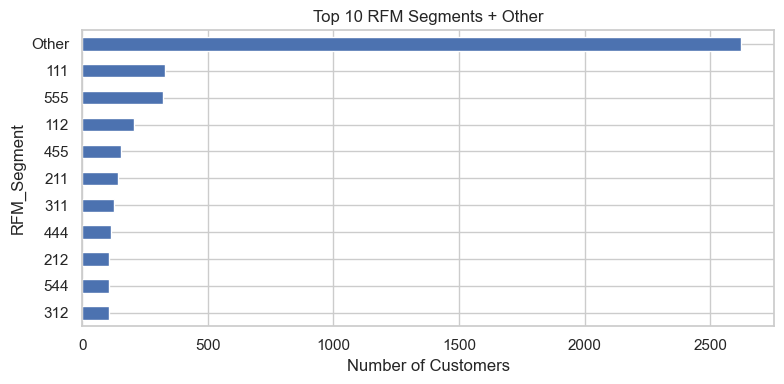

In [5]:
# 1. Top 10 + Other
counts   = rfm['RFM_Segment'].value_counts()
top10    = counts.nlargest(10)
others   = counts.drop(top10.index).sum()
plot1    = top10.copy()
plot1['Other'] = others

plot1.sort_values().plot(kind='barh')
plt.title('Top 10 RFM Segments + Other')
plt.xlabel('Number of Customers')
plt.tight_layout()
plt.show()


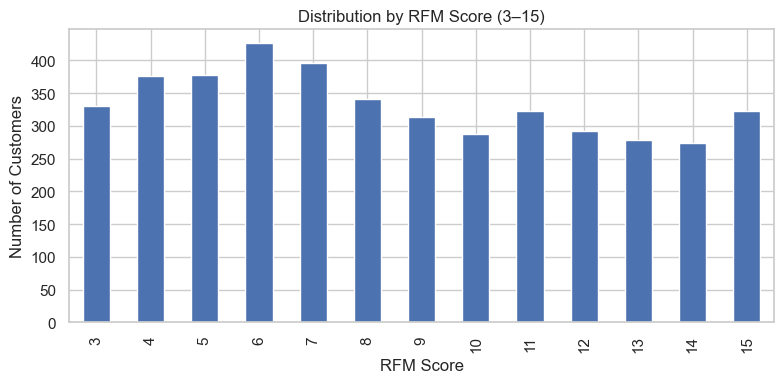

In [6]:
# 2. RFM_Score distribution
score_counts = rfm['RFM_Score'].value_counts().sort_index()
score_counts.plot(kind='bar')
plt.title('Distribution by RFM Score (3–15)')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


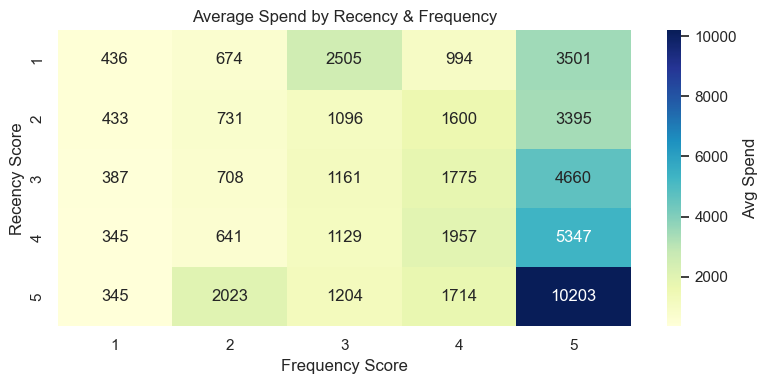

In [7]:
# 3. Heatmap of avg spend by R×F
pivot = rfm.pivot_table(index='R_Score', columns='F_Score', values='MonetaryValue', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label':'Avg Spend'})
plt.title('Average Spend by Recency & Frequency')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.tight_layout()
plt.show()


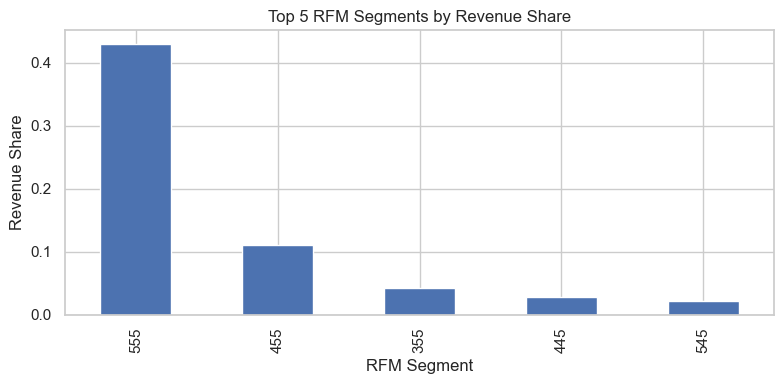

In [8]:
# 4. Top 5 segments by revenue
rev   = rfm.groupby('RFM_Segment')['MonetaryValue'].sum()
share = (rev / rev.sum()).sort_values(ascending=False).head(5)
share.plot(kind='bar')
plt.title('Top 5 RFM Segments by Revenue Share')
plt.xlabel('RFM Segment')
plt.ylabel('Revenue Share')
plt.tight_layout()
plt.show()


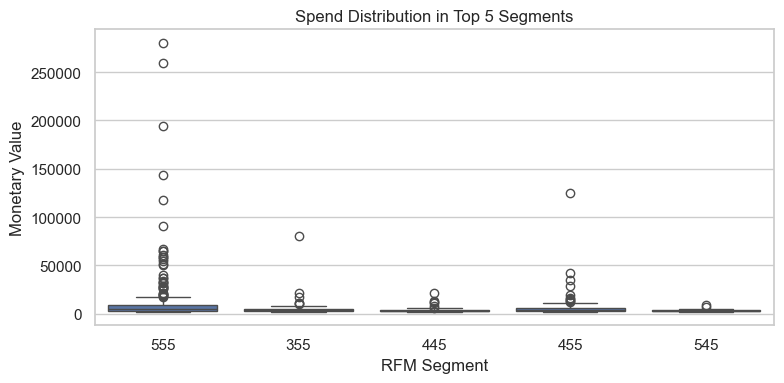

In [9]:
# 5. Boxplot for top 5 segments
top5   = share.index.tolist()
subset = rfm[rfm['RFM_Segment'].isin(top5)]
sns.boxplot(x='RFM_Segment', y='MonetaryValue', data=subset)
plt.title('Spend Distribution in Top 5 Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Monetary Value')
plt.tight_layout()
plt.show()


## 5. Export Results & Next Steps

- **Exported** `rfm` to `data/rfm_segments.csv`.  
- **Next:** build an interactive Streamlit dashboard (`dashboards/app.py`) that allows filtering by date, segment, and drilling into customer profiles.
